In [1]:
import math
import struct

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageEnhance
from tensorflow.python.keras.utils import to_categorical

In [2]:
class ETL9B:
    def __init__(self, path, num, label_num, drop_records=[], seek=0):
        self.labels = label_num
        self.max_nums = num
        self.image_shape = [64, 64]
        self.filename = path
        self.drop_records = drop_records
        self.file = open(self.filename, 'rb')
        self.seek = seek
        self.pad_image = np.zeros([1, 64])

    def is_dropped(self, label, num):
        if self.drop_records:
            for drop_record in self.drop_records:
                if drop_record[0] == label and drop_record[1] == num:
                    return True
        return False

    def _read(self, skip):
        record_size = 576
        self.file.seek(skip * record_size)
        s = self.file.read(record_size)
        r = struct.unpack('>2H4s504s64x', s)
        i1 = Image.frombytes('1', (64, 63), r[3], 'raw')
        return np.array(i1).astype(np.bool)

    def get_chars(self):
        images = []
        labels = []
        seek = self.seek
        for num in range(self.max_nums):
            for label in range(self.labels):
                if not self.is_dropped(label, num):
                    x = self._read(label + seek + self.labels*num)
                    images.append(x)
                    labels.append(label)
                else:
                    seek -= 1
        images = np.array(images)
        pad_image = np.zeros([images.shape[0], 1, images.shape[2]], dtype=np.bool)
        return np.concatenate([images, pad_image], axis=1)[..., np.newaxis], to_categorical(np.asarray(labels), self.labels)

In [3]:
etl9b_path = '/Users/chai/data/etlcdb/ETL9B/'
etl9b_x = []
etl9b_y = []
for i in range(5):
    x, y = ETL9B(etl9b_path + 'ETL9B_' + str(i+1),
                 40, 3036, seek=1).get_chars()
    etl9b_x.extend(x)
    etl9b_y.extend(y)
images, labels = np.asarray(etl9b_x), np.asarray(etl9b_y)

In [4]:
def center_to_corner_box(b):
    return np.array([b[0] - b[2] / 2, b[1] - b[3] / 2, b[0] + b[2] / 2, b[1] + b[3] / 2])

def corner_to_center_box(b):
    return np.array([b[0] + (b[2] - b[0]) / 2, b[1] + (b[3] - b[1]) / 2, b[2] - b[0], b[3] - b[1]])

In [5]:
def show_image_labels(image, boxes, scores, classes):
    ax = plt.axes()
    plt.gray()
    plt.imshow(image)
    for box in boxes:
        color = 'r'
        width = box[2] * image.shape[0]
        height = box[3] * image.shape[1]
        point = [box[0] * image.shape[0]-width/2, box[1] * image.shape[1]-height/2]
        patch = patches.Rectangle(point, width, height, fill=False, color=color)
        ax.add_patch(patch)
        plt.text(point[0], point[1], np.argmax(classes), color=color)
    plt.show()

In [6]:
def create_trim_box(binary_image):
    y, x = np.where(binary_image == True)
    shape = binary_image.shape
    minx = min(x)
    miny = min(y)
    diffx = max(x) - minx
    diffy = max(y) - miny
    return [minx + diffx/2, miny + diffy/2, diffx, diffy]
    # return [(minx + diffx/2)/shape[0], (miny + diffy/2)/shape[1], diffx/shape[0], diffy/shape[1]]

In [7]:
boxes = list(map(create_trim_box, images[..., 0]))

In [8]:
# データの変換
boxes = np.array([center_to_corner_box(box) for box in boxes])
labels = np.argmax(labels, axis=1)

In [10]:
# cast
images = images.astype(np.uint8)
boxes = boxes.astype(np.int8)
labels = labels.astype(np.uint16)

In [11]:
# 複数の配列を1ファイルに書き込み（非圧縮）
out_dir = '/Users/chai/data/etlcdb/numpy/etl9b_2/'
np.save(out_dir + 'images', images)
np.save(out_dir + 'boxes', boxes)
np.save(out_dir + 'labels', labels)

In [15]:
loaded_images = np.load(out_dir + 'images.npy')
loaded_boxes = np.load(out_dir + 'boxes.npy')
loaded_labels = np.load(out_dir + 'labels.npy')

In [16]:
num_labels = 3036
loaded_boxes = np.array([corner_to_center_box(box) for box in loaded_boxes])
loaded_labels = to_categorical(loaded_labels, num_labels)

In [17]:
image_size = loaded_images.shape[1:3]
loaded_boxes[..., :2] = loaded_boxes[..., :2] / image_size
loaded_boxes[..., 2:4] = loaded_boxes[..., 2:4] / image_size

In [18]:
num = 200

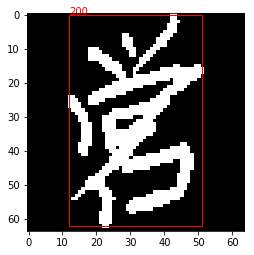

In [19]:
show_image_labels(loaded_images[num, ..., 0], [loaded_boxes[num]], [1], [loaded_labels[num]])

In [20]:
loaded_boxes[num]

array([0.4921875, 0.484375 , 0.609375 , 0.96875  ])